[View in Colaboratory](https://colab.research.google.com/github/AlliterativeAnchovies/fastDL/blob/master/fastDL.ipynb)

First we download the libraries we need:

In [0]:
!pip install fastai
!pip install spacy
!python -m spacy download en

    100% |████████████████████████████████| 122kB 3.5MB/s 
    100% |████████████████████████████████| 496.4MB 20kB/s 
    100% |████████████████████████████████| 3.6MB 1.1MB/s 
    100% |████████████████████████████████| 2.2MB 2.0MB/s 
    100% |████████████████████████████████| 61kB 4.1MB/s 
    100% |████████████████████████████████| 51kB 15.3MB/s 
    100% |████████████████████████████████| 184kB 5.1MB/s 
    100% |████████████████████████████████| 1.5MB 1.7MB/s 
    100% |████████████████████████████████| 51kB 3.7MB/s 
    100% |████████████████████████████████| 112kB 5.9MB/s 
    100% |████████████████████████████████| 71kB 4.2MB/s 
    100% |████████████████████████████████| 901kB 1.3MB/s 
    100% |████████████████████████████████| 11.6MB 1.5MB/s 
    100% |████████████████████████████████| 92kB 3.4MB/s 
    100% |████████████████████████████████| 112kB 4.2MB/s 
    100% |████████████████████████████████| 81kB 3.3MB/s 
    100% |████████████████████████████████| 1.5MB 1.6MB/s 


In [0]:
import xml.etree.ElementTree as ET
import csv
from fastai.text import *
from fastai.dataset import *
from fastai.conv_learner import *
from fastai import lm_rnn
import matplotlib.pyplot as plt
import PIL
import spacy
import html

spacy.load("en")
re1 = re.compile(r'  +')

def loadTextFile(fileName):
  toReturn = Path(fileName).open('r').read()#!cat {fileName} >/dev/null
  return toReturn

def createModelDirectory(name,trainingDataPath = "",validationDataPath = ""):
  #This function creates a new directory called "name", with subdirectories:
  # "trainingData", "validationData", "models", "csvs", "misc"
  #All are self explanatory (example: "csvs" holds saved csvs), except perhaps
  # "misc", which is just a catch-all for things that do not belong in other
  # subdirectories.
  #trainingDataPath and validationDataPath are expected to be either .tar,
  #.tar.gz, .zip, or a folder.  
  #Folders should be passed with a /. at the end
  #This function should work in other cases as well, but it is not
  #guaranteed.  If they are empty strings, this function will ignore them.
  !echo "Making directories..."
  !mkdir {name}
  %cd {name}
  !mkdir trainingData
  !mkdir validationData
  !mkdir models
  !mkdir csvs
  !mkdir misc
  if trainingDataPath != "":
    !echo "copying "{trainingDataPath}
    !cp -r ../{trainingDataPath} trainingData
    %cd trainingData
    if trainingDataPath[-3:] == ".gz":
      !echo "unzipping "{trainingDataPath}
      !gzip -d {trainingDataPath}
      trainingDataPath = trainingDataPath[:-3]
    if trainingDataPath[-4:] == ".tar":
      !echo "unzipping "{trainingDataPath}
      !tar xopf {trainingDataPath}
    if trainingDataPath[-4:] == ".zip":
      !echo "unzipping "{trainingDataPath}
      !unzip -qq {trainingDataPath}
  if validationDataPath != "":
    %cd ..
    !echo "copying "{validationDataPath}
    !cp -r ../{validationDataPath} validationData
    %cd validationData
    if validationDataPath[-3:] == ".gz":
      !echo "unzipping "{validationDataPath}
      !gzip -d {validationDataPath}
      validationDataPath = validationDataPath[:-3]
    if validationDataPath[-4:] == ".tar":
      !echo "unzipping "{validationDataPath}
      !tar xopf {validationDataPath}
    if validationDataPath[-4:] == ".zip":
      !echo "unzipping "{validationDataPath}
      !unzip -qq {validationDataPath}
  %cd ../..
  !echo "Finished"
  
class Task:
  
  def removeFileEnding(x):
    #Returns everything before the first period, class function.
    return x.split('.')[0]
  
  def __init__(self,direcIn,name,rawData = "",annotations = ""):
    self.name = name
    self.direcIn = direcIn
    self.rawData = rawData
    self.annotations = annotations
    self.allDataFiles_t = []
    self.allAnnotationFiles_t = []
    self.allDataFiles_v = []
    self.allAnnotationFiles_v = []
    self.trainingDict = {}
    self.validationDict = {}
    self.allClasses = []
    self.fastAIData = None
    self.csvValidationIndices = []
    self.fastAIModel = None
    self.curArchitecture = resnet34
    self.validationPredictions = None
    self.booleanPredictions = []
    self.predictionProbabilities = []
    self.allDataIsConsideredTraining = True
    self.curTransformsFromModel = None
    self.curDataSize = 64
    self.lastCSVName = None
    self.tokenizerData = None
    self.trainingDataFrame = None
    self.validationDataFrame = None
    self.intToString = None
    self.stringToInt = None
    self.wordFrequency = None
    self.tokenizedTraining = None
    self.tokenizedTrainingLabels = None
    self.tokenizedValidation = None
    self.tokenizedValidationLabels = None
    self.typeOfData = None
    self.preTokenizedTraining = None
    self.preTokenizedValidation = None
    
  def copy(self,newName,appendToDirec = True):
    #Creates an exact copy of this task with name newName, 
    # adds it to the directory if appendToDirec is true,
    # and returns it.
    #This isn't really supposed to be used, it's meant so that I can update old
    # Task objects to updated code if I have to change something at runtime
    # without having to create a new one from scratch and go through all the
    # computationally expensive processes.
    # (which is often when adding features and debugging)
    toReturn = Task(self.direcIn,newName,self.rawData,self.annotations)
    toReturn.allDataFiles_t = self.allDataFiles_t
    toReturn.allAnnotationFiles_t = self.allAnnotationFiles_t
    toReturn.allDataFiles_v = self.allDataFiles_v
    toReturn.allAnnotationFiles_v = self.allAnnotationFiles_v
    toReturn.trainingDict = self.trainingDict
    toReturn.validationDict = self.validationDict
    toReturn.allClasses = self.allClasses
    toReturn.fastAIData = self.fastAIData
    toReturn.csvValidationIndices = self.csvValidationIndices
    toReturn.fastAIModel = self.fastAIModel
    toReturn.curArchitecture = self.curArchitecture
    toReturn.validationPredictions = self.validationPredictions
    toReturn.booleanPredictions = self.booleanPredictions
    toReturn.predictionProbabilities = self.predictionProbabilities
    toReturn.allDataIsConsideredTraining = self.allDataIsConsideredTraining
    toReturn.curTransformsFromModel = self.curTransformsFromModel
    toReturn.curDataSize = self.curDataSize
    toReturn.lastCSVName = self.lastCSVName
    toReturn.tokenizerData = self.tokenizerData
    toReturn.trainingDataFrame = self.trainingDataFrame
    toReturn.validationDataFrame = self.validationDataFrame
    toReturn.typeOfData = self.typeOfData
    toReturn.preTokenizedTraining = self.preTokenizedTraining
    toReturn.preTokenizedValidation = self.preTokenizedValidation
    toReturn.intToString = self.intToString
    toReturn.stringToInt = self.stringToInt
    toReturn.wordFrequency = self.wordFrequency
    toReturn.tokenizedTraining = self.tokenizedTraining
    toReturn.tokenizedTrainingLabels = self.tokenizedTrainingLabels
    toReturn.tokenizedValidation = self.tokenizedValidation
    toReturn.tokenizedValidationLabels = self.tokenizedValidationLabels
    if appendToDirec: self.direcIn.tasks.append(toReturn)
    return toReturn
  
  def removeDuplicateAnnotations(self):
    #This assumes your annotations are not order dependent
    #that isn't always a safe assumption, but it's unusual to want to remove
    #duplicates in ordered lists so unless problems arise, we'll stick with this.
    #Another assumption is that trainingDict/validationDict are lists
    for k, v in self.trainingDict.items():
      self.trainingDict[k] = list(set(v))
    for k, v in self.validationDict.items():
      self.validationDict[k] = list(set(v))
      
  def findClassRange(self):
    if self.fastAIModel is None:
      for k, v in self.trainingDict.items():
        self.allClasses = self.allClasses + v
      self.allClasses = list(set(self.allClasses))
      for k, v in self.validationDict.items():
        self.allClasses = self.allClasses + v
      self.allClasses = list(set(self.allClasses))
    else:
      self.allClasses = self.fastAIData.classes
    return self.allClasses
    
  def matchFiles(self,dataFunc = removeFileEnding,annotateFunc = None):
    #Links every data file with its annotation
    #Takes in 2 functions acting on the filename, the first one on the data
    #and the second on the annotations.  If no func is provided for annotations,
    #it uses the same as datafunc
    #The simplest func would be to remove file endings, so that is the default
    if annotateFunc == None:
      annotateFunc = dataFunc
    self.allDataFiles_t = !ls -1 {self.direcIn.name}/trainingData/{self.rawData}
    self.allAnnotationFiles_t = !ls -1 {self.direcIn.name}/trainingData/{self.annotations}
    self.allDataFiles_v = !ls -1 {self.direcIn.name}/validationData/{self.rawData}
    self.allAnnotationFiles_v = !ls -1 {self.direcIn.name}/validationData/{self.annotations}
    
    #Apply the match functions
    datas = list(map(lambda x: map(lambda y: (dataFunc(y),y),x),[self.allDataFiles_t,self.allDataFiles_v,]))
    annotes = list(map(lambda x: map(lambda y: (annotateFunc(y),y),x),[self.allAnnotationFiles_t,self.allAnnotationFiles_v]))
    
    #Turn them into dictionaries instead of tuples
    dataDict_t = dict((x, y) for x, y in list(datas[0]))
    dataDict_v = dict((x, y) for x, y in list(datas[1]))
    annoteDict_t = dict((x, y) for x, y in list(annotes[0]))
    annoteDict_v = dict((x, y) for x, y in list(annotes[1]))
    
    #Get all matches:
    intersects_t = set(dataDict_t.keys()) & set(annoteDict_t.keys())#set(map(lambda x: x[0],dataDict_t)) & set(map(lambda x: x[0],annoteDict_t))
    intersects_v = set(dataDict_v.keys()) & set(annoteDict_v.keys())#set(map(lambda x: x[0],dataDict_v)) & set(map(lambda x: x[0],annoteDict_v))
    self.trainingDict = dict((dataDict_t[a],annoteDict_t[a]) for a in intersects_t)
    self.validationDict = dict((dataDict_v[a],annoteDict_v[a]) for a in intersects_v)
    
    
  def deXMLAnnotations(self,deXMLList,grabText=True):
    #This function takes in a list of xml paths and transforms annotation data
    #into a list of just the values of the data found at those paths for each object
    #For example, test.xml = <person><name>bob</name></person>
    # yourtask.deXMLAnnotations([".//person.name"]) would transform
    # the annotation data from being stored as the string "test.xml" to being
    # stored as the list [<XMLElement: "bob">] (if grabText is true, is just ["bob"])
    print("De-annotating... (for large data sets, this may take a while)")
    for k, v in self.trainingDict.items():
      root = ET.parse(f"{self.direcIn.name}/trainingData/{self.annotations}/{v}").getroot()
      allVals = map(lambda x: root.findall(x), deXMLList)
      self.trainingDict[k] = [(item.text if grabText else item) for sublist in allVals for item in sublist] 
      # ^^^ comprehension is used to flatten it out (we want 1d array, this is 2d)
    for k, v in self.validationDict.items():
      root = ET.parse(f"{self.direcIn.name}/validationData/{self.annotations}/{v}").getroot()
      allVals = map(lambda x: root.findall(x), deXMLList)
      self.validationDict[k] = [(item.text if grabText else item) for sublist in allVals for item in sublist]
    print("De-annotation complete")
    
  def mergeTrainingAndValidation(self):
    #self.trainingDict.update(self.validationDict)
    #self.validationDict = []
    self.allDataIsConsideredTraining = True
    
  def makeCSV(self,csvname):
    print("Making csvs...")
    csvname = csvname[:-4] if csvname[-4:] == ".csv" else csvname
    trdata = [[f"trainingData/{self.rawData}/{k}", ' '.join(v)] for k, v in self.trainingDict.items()]
    #valdata = [] if self.allDataIsConsideredTraining else [[f"validationData/{testTask.rawData}/{k}", ' '.join(v)] for k, v in self.validationDict.items()]
    valdata = [[f"validationData/{self.rawData}/{k}", ' '.join(v)] for k, v in self.validationDict.items()]
    with open(f"{self.direcIn.name}/csvs/{csvname}_train.csv", 'w') as f:
      f.truncate()
      writer = csv.writer(f)
      rowdata = trdata
      writer.writerows(rowdata)
    with open(f"{self.direcIn.name}/csvs/{csvname}_val.csv", 'w') as f:
      f.truncate()
      writer = csv.writer(f)
      rowdata = valdata
      writer.writerows(rowdata)
    with open(f"{self.direcIn.name}/csvs/{csvname}_all.csv", 'w') as f:
      f.truncate()
      writer = csv.writer(f)
      rowdata = trdata + valdata
      writer.writerows(rowdata)
    self.csvValidationIndices = list(range(len(trdata),len(trdata) + len(valdata) - 1))
    self.lastCSVName = csvname
    print(f"Done.   3 Csvs made: {self.direcIn.name}/csvs/{csvname}_train.csv, {self.direcIn.name}/csvs/{csvname}_val.csv, and {self.direcIn.name}/csvs/{csvname}_all.csv")
  
  def makeCSVFromFolderCategories(self,csvname,folderCategories):
    #First we have to create the training and validation dictionaries
    for f in folderCategories:
      #We want to match up the f/filename with [f] (made an array b/c of multilabel classifying)
      self.allDataFiles_t = !ls -1 {self.direcIn.name}/trainingData/{self.rawData}/{f}
      self.allDataFiles_v = !ls -1 {self.direcIn.name}/validationData/{self.rawData}/{f}
      for a in self.allDataFiles_t:
        self.trainingDict[f"{f}/{a}"] = [f]
      for a in self.allDataFiles_v:
        self.validationDict[f"{f}/{a}"] = [f]
    self.makeCSV(csvname)
    self.allClasses = folderCategories
  
  def prepImageDataForFastAI(self,modelArchitecture = resnet34, dataSize = 64):
    self.typeOfData = "IMAGE"
    self.curArchitecture = modelArchitecture
    self.curDataSize = dataSize
    _, self.curTransformsFromModel = tfms_from_model(self.curArchitecture, self.curDataSize) #the uncaptured result (_) is training transforms, including flips and such
    self.fastAIData = ImageClassifierData.from_csv(f"{self.direcIn.name}", f"",f"{self.direcIn.name}/csvs/{self.lastCSVName}_all.csv",tfms=tfms_from_model(modelArchitecture, dataSize),skip_header = False, val_idxs = None if self.csvValidationIndices == [] or self.allDataIsConsideredTraining else self.csvValidationIndices)
    self.allClasses = self.fastAIData.classes
    
  def prepTextDataForFastAI(self,csvname = "textdata",chunksize = 2000,vocabularySize = 6000,minimumWordFrequency = 2):
    self.typeOfData = "TEXT"
    #prep data for pandas-ification
    trainingTexts,trainingLabels = ( list(zip(*  imdbTempTask.trainingDict.items()  ))  )
    validationTexts,validationLabels = ( list(zip(*  imdbTempTask.validationDict.items()  ))  )
    
    #convert files to the actual texts
    print("Opening text files...")
    trainingTexts = list ( map(lambda x: loadTextFile(f"{self.direcIn.name}/trainingData/{self.rawData}/{x}")  , trainingTexts)  )
    validationTexts = list ( map(lambda x: loadTextFile(f"{self.direcIn.name}/validationData/{self.rawData}/{x}")  , validationTexts)  )
    print("All text files have been successfully perused.")
    
    
    #convert labels to integers since pandas expects that
    #note that this will only work for single label classification currently
    trainingLabels = list( map(lambda x: self.allClasses.index(x[0]), trainingLabels  )   )
    validationLabels = list( map(lambda x: self.allClasses.index(x[0]), validationLabels  )   )
    
    #this is the code that would work for multilabel, but the get_all function messes up with it... :(
    #trainingLabels = list( map(lambda x: list(map(lambda y: self.allClasses.index(y),x)), trainingLabels  )   )
    #validationLabels = list( map(lambda x: list(map(lambda y: self.allClasses.index(y),x)), validationLabels  )   )
    
    #make pandas dataframes
    self.trainingDataFrame = pd.DataFrame({'text':trainingTexts,'labels':trainingLabels},columns=['labels','text'])
    self.validationDataFrame = pd.DataFrame({'text':validationTexts,'labels':validationLabels},columns=['labels','text'])
    
    #save as csv for future reference
    self.trainingDataFrame.to_csv(f"{self.direcIn.name}/csvs/{csvname}_train_pandas.csv", header=False, index=False)
    self.validationDataFrame.to_csv(f"{self.direcIn.name}/csvs/{csvname}_validation_pandas.csv", header=False, index=False)
    print(f"2 Csvs made: {self.direcIn.name}/csvs/{csvname}_train_pandas.csv and {self.direcIn.name}/csvs/{csvname}_validation_pandas.csv")
    
    #immediately load from csvs, not quite sure why I need to do this..., but I suspect its to set the chunksize
    #it doesn't take much time, so it's okay...
    self.trainingDataFrame = pd.read_csv(f"{self.direcIn.name}/csvs/{csvname}_train_pandas.csv", header=None, chunksize=chunksize)
    self.validationDataFrame = pd.read_csv(f"{self.direcIn.name}/csvs/{csvname}_validation_pandas.csv", header=None, chunksize=chunksize)
    
    #tokenize texts part 1
    print("Tokenizing...  This will take a while")
    self.preTokenizedTraining, self.tokenizedTrainingLabels = self.get_all(self.trainingDataFrame, 1)
    self.preTokenizedValidation, self.tokenizedValidationLabels = self.get_all(self.validationDataFrame, 1)
    
    #get rid of these two lines when moving to multilabel classification.
    self.tokenizedTrainingLabels = np.squeeze(self.tokenizedTrainingLabels)
    self.tokenizedValidationLabels = np.squeeze(self.tokenizedValidationLabels)
    
    #find frequencies
    self.wordFrequency = Counter(p for o in self.preTokenizedTraining for p in o)
    self.intToString = [o for o,c in self.wordFrequency.most_common(vocabularySize) if c>minimumWordFrequency]
    self.intToString.insert(0, '_pad_')
    self.intToString.insert(0, '_unk_')
    self.stringToInt = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(self.intToString)})
    
    #tokenize texts part 2
    self.tokenizedTraining = np.array([[self.stringToInt[o] for o in p] for p in self.preTokenizedTraining])
    self.tokenizedValidation = np.array([[self.stringToInt[o] for o in p] for p in self.preTokenizedValidation])
    print("Tokenizing over!  Data preparation complete.")
  
  def setType(self,typename):
    self.typeOfData = typename
  
  def createModel(self):
    if self.typeOfData == "IMAGE":
      #Creating an image model is easy
      self.fastAIModel = ConvLearner.pretrained(self.curArchitecture, self.fastAIData)
    elif self.typeOfData == "TEXT":
      #Creating a text model is ugly
      bptt,em_sz,nh,nl = 70,400,1150,3
      vs = len(self.intToString)
      opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
      bs = 48
      min_lbl = self.tokenizedTrainingLabels.min()
      self.tokenizedTrainingLabels -= min_lbl
      self.tokenizedValidationLabels -= min_lbl
      c=int(self.tokenizedTrainingLabels.max())+1
      trainingTextDataset = TextDataset(self.tokenizedTraining, self.tokenizedTrainingLabels)
      validationTextDataset = TextDataset(self.tokenizedValidation, self.tokenizedValidationLabels)
      trn_samp = SortishSampler(self.tokenizedTraining, key=lambda x: len(self.tokenizedTraining[x]), bs=bs//2)
      val_samp = SortSampler(self.tokenizedValidation, key=lambda x: len(self.tokenizedValidation[x]))
      trainingDataLoader = DataLoader(trainingTextDataset, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
      validationDataLoader = DataLoader(validationTextDataset, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
      md = ModelData(f"{self.direcIn.name}/models", trainingDataLoader, validationDataLoader)
      dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5#dropouts
      m = lm_rnn.get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])
      opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
      self.fastAIModel = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
      self.fastAIModel.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
      self.fastAIModel.clip=25.
      self.fastAIModel.metrics = [accuracy]
    else:
      print("Error - Task has no type.  You can fix this with Task.setType('IMAGE' or 'TEXT')")
    
    
    
  def trainModel(self,learningRate = 0.2, epochs = 1, startingCycleEpochLength = 1, subsequentCycleEpochLengthMultiplier = 1):
    print("Starting training...  This may take a long time.")
    self.fastAIModel.fit(learningRate, epochs, cycle_len=startingCycleEpochLength, cycle_mult=subsequentCycleEpochLengthMultiplier)
    print("Training over.")
    print("Storing predictions...")
    self.validationPredictions = self.fastAIModel.predict()
    self.booleanPredictions = np.argmax(self.validationPredictions, axis=1)  # from log probabilities to 0 or 1
    #^^^ NOTE TO SELF, this only works for 1 category currently due to argmax
    self.predictionProbabilities = np.exp(self.validationPredictions[:,1])
    print("Predictions stored.")
  
  #predicts given an index in the validation set
  def predictFromIndex(self,n): return self.fastAIModel.predict_array(self.fastAIData.val_ds[n][0][None])
  
  #predicts given an array of raw data
  #Warning - the array is unlikely to be scaled properly if you pass it in, because there is preprocessing that fastAI does
  #If doing image processing, you are much better off using predictFromImageFile
  def predictFromArray(self,arrayToPredictFrom): return self.fastAIModel.predict_array(arrayToPredictFrom[None])
  
  #Given an absolute file name, it will predict the output
  def predictFromImageFile(self,fileName): return self.predictFromArray(self.curTransformsFromModel(open_image(fileName)))
  
  def saveModel():
    self.fastAIModel.save(f"{self.direcIn.name}/models/{self.name}")
    
  def loadModel():
    self.fastAIModel = ConvLearner.pretrained(self.curArchitecture, self.fastAIData).load(f"{self.direcIn.name}/models/{self.name}")
  
  
  #The grab random display code is taken pretty much verbatim from here, although names changed to fit with theme
  #https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1.ipynb
  #def randomByMask(self,mask,amount = 4): return np.random.choice(np.where(mask)[0], amount, replace=False)
  #def getRandomValidationFromCorrectness(self,is_correct=True,amount = 4): return self.randomByMask((self.booleanPredictions == self.fastAIData.val_y)==is_correct, amount)
  
  def plots(self,ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
  def load_img_id(self,ds, idx): return np.array(PIL.Image.open(f"{self.direcIn.name}/{ds.fnames[idx]}"))

  def drawRandomPlots(self, amount = 4):
      idxs = np.random.choice(len(self.fastAIData.val_ds)-1,amount,replace=False)
      return self.drawPlots(idxs)
                     
  def drawPlots(self, idxs):
      imgs = [self.load_img_id(self.fastAIData.val_ds,x) for x in idxs]
      title_probs = [f"{self.fastAIData.val_ds.fnames[x].split('/')[-1]} :{self.predictionProbabilities[x]}" for x in idxs]
      return self.plots(imgs, rows=1, titles=title_probs, figsize=(16,8))
                     
  #Next three functions taken directly from link below, meant for loading data from a pandas dataframe correctly
  #https://github.com/fastai/fastai/blob/master/courses/dl2/imdb.ipynb
  def fixup(self,x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))
    
  def get_texts(self,df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\nxbos xfld 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' xfld {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(self.fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)
                     
  def get_all(self,df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = self.get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels
  
class ModelDirectory:
                     
  def copy(self):
    #This is used for debuggings and whatnots
    toReturn = ModelDirectory(self.name,self.trainingDataPath,self.validationDataPath,False)
    toReturn.tasks = []
    return toReturn
                     
  def __init__(self,name,trainingDataPath = "",validationDataPath = "",create=True):
    self.name = name
    self.trainingDataPath = trainingDataPath
    self.validationDataPath = validationDataPath
    self.tasks = []
    if create: createModelDirectory(name,trainingDataPath,validationDataPath)
    
  def giveTask(self,taskname,rawData = "",annotations = "",folderCategories = []):
    newTask = Task(self,taskname,rawData,annotations)
    if folderCategories: #if folderCategories is not empty
      newTask.makeCSVFromFolderCategories(self.name,folderCategories)
    self.tasks.append(newTask)
    return newTask
  
  def getTask(self,taskname):
    for a in self.tasks:
      if a.name == taskname:
        return a
    return None
                     
  def extractJumbledValidation(self,foldersToPrepend,fileLocation):
    curdirec = !pwd
    curdirec = curdirec[0]
    %cd {self.name}/validationData
    stringToAppend = "/".join(foldersToPrepend)
    for folder in foldersToPrepend:
      !mkdir {folder}
      %cd {folder}
    %cd /{curdirec}/{self.name}
    !cp -r trainingData/{fileLocation} validationData/{stringToAppend}
    %cd /{curdirec}
                     
                     

#PascalVOC2012 Tutorial

For Image Recognition

Pascal VOC: https://github.com/fastai/fastai/blob/master/courses/dl2/pascal.ipynb

I'm specifically using 2012 VOC

Download the data:

In [0]:
!wget http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
!wget http://pjreddie.com/media/files/VOC2012test.tar

Create a directory and task:

In [0]:
theModelDirec = ModelDirectory("taskTester","VOCtrainval_11-May-2012.tar","VOC2012test.tar")

In [0]:
theTask = theModelDirec.giveTask("classification","VOCdevkit/VOC2012/JPEGImages","VOCdevkit/VOC2012/Annotations")

ModelDirectories are basically file managers that, given training and validation data, will organize a directory and facilitate the creation of models from that data.

Tasks are specific interpretations of that data.  For example, the PascalVOC dataset, what we're using, has 5 different tasks that the data is labeled for.  Obviously, most of the time we'll be training a model to focus on just 1 of those tasks, but we don't want to throw away all the other data.  So a ModelDirectory can have multiple tasks.  We will just be focused on the multilabel classification task for this dataset.  We named the task 'classification' and gave it the directory of the data and its annotations.

Like previously mentioned, we only want a task to focus on specific data.  Since our annotations are in .xml format, we use the deXMLAnnotations function.  It takes in a list of xpath strings and converts all xml data into just the text data found by those strings.

Before that, though, we need to call "matchFiles".  That function links up the image data with the annotation data.  By default, matchFiles matches them by filename - test_image.jpg will be matched with test_image.xml.  Sometimes, your dataset may use a different system.  If so, matchFiles can take in functions as an argument which will you can use to match the files. (the default argument just removes the file extension.  See documentation for more information on how it works)

In [0]:
theTask.matchFiles()
theTask.deXMLAnnotations([".//object/name"])

Now, we want to do some final polishing on the data by removing data that had the same label twice (e.g. test.jpg having lables "cow cow cow cow" instead of "cow").  This isn't a necessary thing to do, sometimes we may want there to be repeated labels.  However, that's to complicated for our example.

Next, we want to make a csv file from all this data.  makeCSV takes a string 'a' and creates 3 csv files, a_train, a_val, and a_all.  This is necessary as model training expects everything in csv format.

For this specific dataset, we also call mergeTrainingAndValidation, which causes the dataset to consider everything 'training' and then on model training time take a random 20% to be the validation.  The reason why is because, for some reason, the only labeled validation data in this dataset is that of the person class!

In [0]:
theTask.removeDuplicateAnnotations()
theTask.mergeTrainingAndValidation()
theTask.makeCSV("test")

Finally, we can create a fastAI model!  First, we do one last data manipulation to convert our csvs into fastAI data.  Then, we create an empty° model and train it.

°The model is not actually empty, we grab a pretrained one.  That's one of the main bonuses of fastAI, it'd be stupid not to use it!

prepDataForFastAI actually takes in 2 arguments, the model architecture and the size the images should be scaled to.  By default they are resnet34 and 64 by 64.

trainModel() also has arguments it can take, such as learning rate and cycle length.  Check the source to see all.

In [0]:
theTask.prepImageDataForFastAI()
theTask.createModel()
theTask.trainModel()

Of course, training a model isn't very useful if you can't use it!  So let's grab a random-ish image and check our model's predictions on it:

In [0]:
randomImages = !ls taskTester/validationData/VOCdevkit/VOC2012/JPEGImages
randomImage = np.random.choice(randomImages)
randomFileName = f"taskTester/validationData/VOCdevkit/VOC2012/JPEGImages/{randomImage}"
display(PIL.Image.open(randomFileName))
predicts = theTask.predictFromImageFile(randomFileName)
print(predicts)
print(f"The most prevalent object is predicted to be: {theTask.allClasses[np.argmax(predicts)]}")

#Other Examples
Dogs Vs Cats and Imdb

##Dogs Vs Cats

Download the data and prepare the task:

In [0]:
!wget http://files.fast.ai/data/dogscats.zip

In [0]:
modelDirec = ModelDirectory("dogsVcats",trainingDataPath = "dogscats.zip",validationDataPath = "")

Making directories...
/content/dogsVcats
copying dogscats.zip
/content/dogsVcats/trainingData
unzipping dogscats.zip
/content
Finished


As you can see, the training and validation sets come together in dogsVcats, so we want to extract that
to the validation path in modelDirec

For this we use extractJumbledValidation - it takes a list of directories to prepend to the validation set, and a path to the files themselves.  Directories are relative to dogsVcats/trainingData

In this example, we move all files from dogsVcats/trainingData/**dogscats/valid** to dogsVcats/validationData/**dogscats/train**

Emboldened stuff is what actually depends on the input you gave it.  It is important that, after *dogsVcats/trainingData/* and *dogsVcats/validationData*, both the validations and the trainings have the same path, hence why we renamed it to dogscats/train instead of dogscats/valid.  The reason why is that the Task class expects this.

In [0]:
tp1 = !ls dogsVcats/trainingData/dogscats
tp2 = !ls dogsVcats/validationData
print(tp1)
print(tp2)

['models', 'sample', 'test1', 'train', 'valid']
[]


In [0]:
modelDirec.extractJumbledValidation(["dogscats","train"],"dogscats/valid/.")

/content/dogsVcats/validationData
/content/dogsVcats/validationData/dogscats
/content/dogsVcats/validationData/dogscats/train
/content/dogsVcats
/content


In [0]:
!ls dogsVcats/validationData/dogscats

train


Now we can finally move on to the task creation.  Unlike PascalVoc, annotations are not a seperate file, but are instead the folders they come in.

In [0]:
theTask = modelDirec.giveTask("classification","dogscats/train",folderCategories=["cats","dogs"])

Making csvs...
Done.   3 Csvs made: dogsVcats/csvs/dogsVcats_train.csv, dogsVcats/csvs/dogsVcats_val.csv, and dogsVcats/csvs/dogsVcats_all.csv


Notice how csvs are automatically made - it means we actually have much less manual work to do then PascalVOC (note: if you wanted to make your own CSVs,  makeCSV() still works for you so you can do some dataprocessing and then just overwrite these csvs, if you don't like how the csvs turned out)

In [0]:
theTask.prepImageDataForFastAI()
theTask.createModel()
theTask.trainModel()

Starting training...  This may take a long time.


epoch      trn_loss   val_loss   accuracy   
    0      0.311275   0.251646   0.8868    

Training over.
Storing predictions...
Predictions stored.


Finally, let's make a prediction:

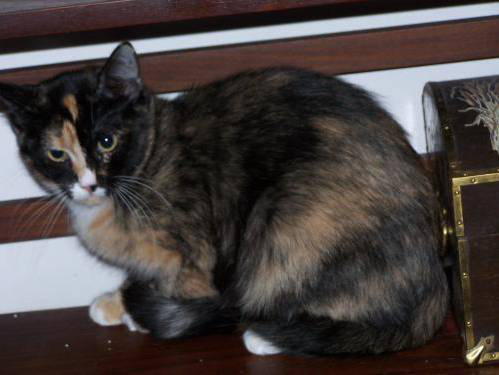

[[-0.06053 -2.83476]]
Hopefully this says 'cats': cats


In [0]:
randomImages = !ls dogsVcats/validationData/dogscats/train/cats
randomImage = np.random.choice(randomImages)
randomFileName = f"dogsVcats/validationData/dogscats/train/cats/{randomImage}"
display(PIL.Image.open(randomFileName))
predicts = theTask.predictFromImageFile(randomFileName)
print(predicts)
print(f"Hopefully this says 'cats': {theTask.allClasses[np.argmax(predicts)]}")

##IMDB Review Negativity

In [0]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz


Redirecting output to ‘wget-log’.


In [0]:
imdbDirec = ModelDirectory("imdbReviews","aclImdb_v1.tar.gz")

Making directories...
mkdir: cannot create directory ‘imdbReviews’: File exists
/content/imdbReviews
mkdir: cannot create directory ‘trainingData’: File exists
mkdir: cannot create directory ‘validationData’: File exists
mkdir: cannot create directory ‘models’: File exists
mkdir: cannot create directory ‘csvs’: File exists
mkdir: cannot create directory ‘misc’: File exists
copying aclImdb_v1.tar.gz
/content/imdbReviews/trainingData
unzipping aclImdb_v1.tar.gz
gzip: aclImdb_v1.tar already exists; do you wish to overwrite (y or n)? y
unzipping aclImdb_v1.tar
/content
Finished


If we look at the file structure:

imdbReviews/trainingData/aclImdb/train has a neg and a pos folder

imdbReviews/trainingData/aclImdb/test also has neg and pos, and is the validation folder.

Like dogsVcats, we will want to use extractJumbledValidation

In [0]:
imdbDirec.extractJumbledValidation(["aclImdb","train"],"aclImdb/test/.")

/content/imdbReviews/validationData
mkdir: cannot create directory ‘aclImdb’: File exists
/content/imdbReviews/validationData/aclImdb
mkdir: cannot create directory ‘train’: File exists
/content/imdbReviews/validationData/aclImdb/train
/content/imdbReviews
/content


In [0]:
imdbTask = imdbDirec.giveTask("classification","aclImdb/train",folderCategories=["pos","neg"])

Making csvs...
Done.   3 Csvs made: imdbReviews/csvs/imdbReviews_train.csv, imdbReviews/csvs/imdbReviews_val.csv, and imdbReviews/csvs/imdbReviews_all.csv


Now you may have noticed something different about this dataset - it's text data, not image data!  They are fundamentally different!  Instead of prepImageDataForFastAI, we will use prepTextDataForFastAI.  Unfortunately, this will take a long time - tokenizing all of the text data takes a long time!

In [0]:
imdbTask.prepTextDataForFastAI()

Opening text files...
All text files have been successfully perused.
2 Csvs made: imdbReviews/csvs/textdata_train_pandas.csv and imdbReviews/csvs/textdata_validation_pandas.csv
Tokenizing...  This will take a while
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
Tokenizing over!  Data preparation complete.


Now, the code works exactly the same as on images.

In [0]:
imdbTask.createModel()

In [0]:
imdbTask.trainModel()

Starting training...  This may take a long time.


  4%|▍         | 40/1042 [28:23<11:51:24, 42.60s/it, loss=0.695]